refer : https://donghwa-kim.github.io/iforest.html

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import numbers
from scipy.stats import gamma
from sklearn.tree import ExtraTreeRegressor
from scipy.sparse import issparse, csc_matrix
from sklearn.externals import six
from sklearn.utils import check_random_state, check_array
from sklearn.ensemble.bagging import BaseBagging
INTEGER_TYPES=(numbers.Integral, np.integer)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
#seed
rng=np.random.RandomState(42)

#Train Data
X=0.3*rng.randn(100,2)
X_train=np.r_[X+2,X-2]
#some regluar Novel Observations
X=0.3*rng.randn(20,2)
X_test=np.r_[X+2,X-2]
#some Abnormal Novel Observations
X_outliers=rng.uniform(low=-4,high=4,size=(20,2))

X_test_normal=pd.concat([pd.DataFrame(X_test), pd.Series(np.repeat(0,X_test.shape[0]))],axis=1)
X_test_abnormal=pd.concat([pd.DataFrame(X_outliers),pd.Series(np.repeat(1,X_outliers.shape[0]))],axis=1)
X_test_df=pd.concat([X_test_normal,X_test_abnormal],axis=0)
X_test_df.columns=['x1','x2','label']

In [6]:
print(X_test_df.head())
print(X_test_df.tail())

         x1        x2  label
0  2.107336  2.168235      0
1  2.324915  2.316141      0
2  1.586699  1.718652      0
3  2.154511  2.154136      0
4  2.154514  3.155819      0
          x1        x2  label
15 -0.067073 -0.212226      1
16 -2.614385 -0.529187      1
17 -0.811962  0.926801      1
18  1.080749 -3.637568      1
19 -1.003099  1.006879      1


Learing only with regular data

In [7]:
X=X_train

make definition of variables by class

In [10]:
class IsolationForest(BaseBagging):
  def __init__(self,
               n_estimators=100,
               max_samples='auto',
               contamination=0.1,
               #if Floating Point, int(number of X.col * max_feature))
               max_features=1.,
               bootstrap=False,
               n_jobs=1,
               random_state=None,
               verbose=0):
    super(IsolationForest, self).__init__(
        base_estimator=ExtraTreeRegressor(
            max_features=1,
            #here above max_features has no links with self.max_features
            splitter='random',
            random_state=random_state),
            bootstrap=bootstrap,
            bootstrap_features=False,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)
    self.contamination = contamination
  
  def _set_oob_score(self, X,y):
    raise NotImplementedError("OOB score not supported by iforest")

In [12]:
clf=IsolationForest(max_samples=100,random_state=rng,max_features=1)
print('max_smaples:',clf.max_samples)
print('random_state:',clf.random_state)
print('max_features:',clf.max_features)

max_smaples: 100
random_state: RandomState(MT19937)
max_features: 1


In [13]:
#if compressed sparse column foramt -> list format
X=check_array(X, accept_sparse=['csc'])
X[0:10,:]

array([[2.14901425, 1.95852071],
       [2.19430656, 2.45690896],
       [1.92975399, 1.92975891],
       [2.47376384, 2.23023042],
       [1.85915768, 2.16276801],
       [1.86097469, 1.86028107],
       [2.07258868, 1.42601593],
       [1.48252465, 1.83131374],
       [1.69615066, 2.0942742 ],
       [1.72759278, 1.57630889]])

In [14]:
issparse(X)

False

In [15]:
#if Input sparse matrix
csc_X=csc_matrix(X)
csc_X.sort_indices()
csc_X.indices[1:10]

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [17]:
rnd=check_random_state(clf.random_state)
rnd

RandomState(MT19937) at 0x7FF4B140E048

In [18]:
# extract y from Uniform randomly to split randomly X without Label
y=rnd.uniform(size=X.shape[0])
y[0:10]

array([0.50313626, 0.85648984, 0.65869363, 0.16293443, 0.07056875,
       0.64241928, 0.02651131, 0.58577558, 0.94023024, 0.57547418])

In [19]:
# ensure that max_sample is in [1,n_samples]:
n_samples=X.shape[0]

In [23]:
# if input type improper,redifite

# 1) str
isinstance(clf.max_samples, six.string_types)
print('self.max_samples:',clf.max_samples)
print('six.string_types:',six.string_types)
print('isinstance:',isinstance(clf.max_samples,six.string_types))

self.max_samples: 100
six.string_types: (<class 'str'>,)
isinstance: False


In [24]:
# 2) integer
isinstance(clf.max_samples, INTEGER_TYPES)
print('self.max_samples:',clf.max_samples)
print('six.string_types:',INTEGER_TYPES)
print('isinstance:',isinstance(clf.max_samples,INTEGER_TYPES))

self.max_samples: 100
six.string_types: (<class 'numbers.Integral'>, <class 'numpy.integer'>)
isinstance: True


In [ ]:
# 3) float

In [26]:
# Tree max_dept == log(n)

max_depth=int(np.ceil(np.log2(max(clf.max_samples,2))))
print('max_depth:',max_depth)

max_depth: 7


Tree for regression to split data

In [27]:
clf.max_samples_=clf.max_samples

In [29]:
#IsolationForest._fit.base_estimator_=ExtraTreeRegressor
clf._fit(X,y,max_depth=max_depth,sample_weight=None)
print(clf.base_estimator)

ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                   random_state=RandomState(MT19937) at 0x7FF4B140E048,
                   splitter='random')


In [30]:
tmp=ExtraTreeRegressor(max_features=1,splitter='random',max_depth=max_depth,random_state=rng)
print(tmp.fit(X,y,sample_weight=None))

ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                   random_state=RandomState(MT19937) at 0x7FF4B140E048,
                   splitter='random')


In [31]:
X=check_array(X,accept_sparse='csr')
n_samples=X.shape[0]

n_samples_leaf=np.zeros((n_samples, clf.n_estimators),order='f')
depths=np.zeros((n_samples,clf.n_estimators),order='f')

In [32]:
print('clf._max_features:',clf._max_features)
print('X.shape[1]:',X.shape[1])
clf._max_features==X.shape[1]

clf._max_features: 1
X.shape[1]: 2


False

In [33]:
#making numerous Tree with selected variable

subsamples_features=True

In [34]:
print(list(enumerate(zip(clf.estimators_,clf.estimators_features_)))[0])
i, (tree,features)=list(enumerate(zip(clf.estimators_, clf.estimators_features_)))[0]

(0, (ExtraTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=7, max_features=1,
                   max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                   random_state=351940553, splitter='random'), array([1])))


In [35]:
X_subset=X[:,features]
leaves_index=tree.apply(X_subset)
leaves_index

array([66, 69, 66, 67, 67, 66, 40, 66, 66, 49, 66, 48, 66, 66, 66, 70, 57,
       52, 40, 66, 66, 66, 63, 69, 41, 66, 67, 67, 66, 67, 66, 53, 69, 67,
       66, 69, 69, 67, 66, 40, 66, 66, 66, 66, 67, 67, 66, 48, 66, 66, 66,
       62, 66, 66, 66, 66, 70, 66, 53, 67, 57, 49, 70, 66, 66, 66, 66, 69,
       66, 51, 69, 66, 67, 49, 66, 66, 66, 63, 66, 67, 67, 61, 66, 70, 63,
       61, 66, 67, 69, 70, 57, 66, 67, 66, 46, 67, 51, 66, 66, 56, 15, 34,
       15, 23, 18, 15,  6, 15, 16,  8, 15,  7, 15, 16, 15, 36, 13, 13,  6,
       16, 16, 15, 15, 32,  6, 15, 20, 27, 15, 30, 15, 13, 34, 31, 15, 34,
       34, 27, 15,  6, 16, 15, 15, 16, 16, 30, 15,  7, 16, 15, 15, 15, 16,
       16, 15, 15, 37, 16, 13, 21, 15,  8, 37, 15, 15, 15, 16, 34, 15, 12,
       34, 16, 26, 12, 16, 16, 16, 15, 16, 20, 26, 15, 16, 36, 15, 15, 16,
       27, 34, 37, 15, 16, 20, 15,  7, 27, 12, 16, 16, 13])

In [39]:
# extract data from each nodes
tree.tree_.n_node_samples

array([100,  52,  49,  43,   3,   2,   1,   1,   1,  40,  36,   5,   2,
         3,  31,  19,  12,   4,   1,   3,   2,   1,   6,   1,   5,   2,
         1,   1,   3,   2,   1,   1,   1,   3,   1,   2,   1,   1,  48,
         2,   1,   1,  46,   8,   7,   5,   1,   4,   1,   3,   2,   1,
         1,   1,  38,   2,   1,   1,  36,   3,   2,   1,   1,   1,  33,
        29,  20,   9,   4,   2,   2])

In [42]:
#data in leaf node
n_samples_leaf[:,i]=tree.tree_.n_node_samples[leaves_index]
n_samples_leaf

array([[20.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  0.,  0., ...,  0.,  0.,  0.],
       [20.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [12.,  0.,  0., ...,  0.,  0.,  0.],
       [12.,  0.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  0.]])

In [43]:
# get path of every row
# node_indicator: 200 obs x 121 node
node_indicator=tree.decision_path(X_subset)
node_indicator

<200x71 sparse matrix of type '<class 'numpy.int64'>'
	with 1498 stored elements in Compressed Sparse Row format>

In [44]:
# get final path length by adding path to every row
node_indicator.sum(axis=1)
np.ravel(node_indicator.sum(axis=1))


array([8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 7, 4, 8, 8, 8,
       7, 8, 4, 8, 8, 8, 8, 8, 8, 5, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 8, 6, 8, 8, 8, 8, 8,
       8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8,
       8, 8, 6, 8, 8, 8, 7, 8, 7, 8, 8, 6, 8, 4, 8, 5, 7, 8, 7, 8, 8, 6,
       8, 7, 8, 8, 8, 5, 8, 8, 7, 8, 8, 8, 8, 7, 7, 8, 8, 7, 8, 8, 8, 8,
       4, 8, 8, 4, 4, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8,
       8, 8, 5, 8, 8, 8, 8, 6, 5, 8, 8, 8, 8, 4, 8, 8, 4, 8, 7, 8, 8, 8,
       8, 8, 8, 8, 7, 8, 8, 5, 8, 8, 8, 7, 4, 5, 8, 8, 8, 8, 7, 7, 8, 8,
       8, 8])

In [45]:
depths[:,i]=np.ravel(node_indicator.sum(axis=1))
depths[:,i]-=1
depths

array([[7., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       ...,
       [7., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.]])

In [46]:
#for loop

for i, (tree, features) in enumerate(zip(clf.estimators_,
                                         clf.estimators_features_)):
  if subsamples_features:
    X_subset=X[:,features]
  else:
    X_subset=X
  leaves_index=tree.apply(X_subset)
  node_indicator=tree.decision_path(X_subset)
  n_samples_leaf[:,i]=tree.tree_.n_node_samples[leaves_index]
  depths[:,i]=np.ravel(node_indicator.sum(axis=1))
  depths[:,i]-=1
depths

array([[7., 7., 7., ..., 7., 7., 7.],
       [7., 7., 7., ..., 5., 5., 6.],
       [7., 7., 7., ..., 7., 7., 6.],
       ...,
       [7., 7., 7., ..., 7., 5., 7.],
       [7., 7., 7., ..., 4., 7., 7.],
       [7., 7., 4., ..., 7., 7., 7.]])

In [47]:
print('n_samples_leaf:',n_samples_leaf.dtype)
isinstance(n_samples_leaf,INTEGER_TYPES)

n_samples_leaf: float64


False

In [48]:
# Normalization

n_samples_leaf_shape=n_samples_leaf.shape
print('n_samples_leaf_shape:',n_samples_leaf_shape)
n_samples_leaf

n_samples_leaf_shape: (200, 100)


array([[20.,  5.,  1., ..., 14.,  7.,  2.],
       [ 2.,  5.,  3., ...,  1.,  1.,  1.],
       [20.,  5.,  3., ..., 14.,  7.,  1.],
       ...,
       [12., 17., 10., ...,  2.,  1.,  8.],
       [12.,  5., 10., ...,  1.,  1.,  8.],
       [ 3.,  5.,  1., ...,  4.,  3.,  1.]])

In [49]:
#1-D vector
n_samples_leaf=n_samples_leaf.reshape((1,-1))
print('n_samples_leaf.shape:',n_samples_leaf.shape)
n_samples_leaf

n_samples_leaf.shape: (1, 20000)


array([[20.,  5.,  1., ...,  4.,  3.,  1.]])

In [50]:
#making space to save path length
average_path_length=np.zeros(n_samples_leaf.shape)
average_path_length.shape

(1, 20000)

In [51]:
# classify nodes (isolated or not)
# <=1
mask=(n_samples_leaf<=1)
# >1
not_mask=np.logical_not(mask)
print('mask:',mask)
print('not_mask:',not_mask)

mask: [[False False  True ... False False  True]]
not_mask: [[ True  True False ...  True  True False]]


In [56]:
#Euler's constant
np.euler_gamma

0.5772156649015329

In [57]:
# calculate length to add average depth length if leaf node is not with 1 row
average_path_length[mask]=1

average_path_length[not_mask]=2. *(
    np.log(n_samples_leaf[not_mask]-1.)+np.euler_gamma)-2.*(
        n_samples_leaf[not_mask]-1.)/n_samples_leaf[not_mask]

average_path_length.reshape(n_samples_leaf_shape)

array([[5.14330929, 2.32702005, 1.        , ..., 4.42718719, 3.02366455,
        0.15443133],
       [0.15443133, 2.32702005, 1.20739236, ..., 1.        , 1.        ,
        1.        ],
       [5.14330929, 2.32702005, 1.20739236, ..., 4.42718719, 3.02366455,
        1.        ],
       ...,
       [4.11688854, 4.81725583, 3.74888048, ..., 0.15443133, 1.        ,
        3.29625163],
       [4.11688854, 2.32702005, 3.74888048, ..., 1.        , 1.        ,
        3.29625163],
       [1.20739236, 2.32702005, 1.        , ..., 1.85165591, 1.20739236,
        1.        ]])

In [58]:
# add average length to cover pracitcal depth with interrupting by Max_depth

depths+=average_path_length.reshape(n_samples_leaf_shape)
depths

array([[12.14330929,  9.32702005,  8.        , ..., 11.42718719,
        10.02366455,  7.15443133],
       [ 7.15443133,  9.32702005,  8.20739236, ...,  6.        ,
         6.        ,  7.        ],
       [12.14330929,  9.32702005,  8.20739236, ..., 11.42718719,
        10.02366455,  7.        ],
       ...,
       [11.11688854, 11.81725583, 10.74888048, ...,  7.15443133,
         6.        , 10.29625163],
       [11.11688854,  9.32702005, 10.74888048, ...,  5.        ,
         8.        , 10.29625163],
       [ 8.20739236,  9.32702005,  5.        , ...,  8.85165591,
         8.20739236,  8.        ]])

In [69]:
# to use repeatably

def _average_path_length(n_samples_leaf):
  if isinstance(n_samples_leaf, INTEGER_TYPES):
    if n_samples_leaf<=1:
      return 1.
    else:
      return 2. *(np.log(n_samples_leaf-1.)+np.euler_gamma)-2.*(
          n_samples_leaf-1.)/n_samples_leaf
  
  else:
    n_samples_leaf_shape=n_samples_leaf.shape
    n_sampels_leaf=n_samples_leaf.reshape((1,-1))
    average_path_length=np.zeros(n_samples_leaf.shape)

    mask=(n_samples_leaf<=1)
    not_mask=np.logical_not(mask)
    
    average_path_length[mask]=1.
    average_path_length[not_mask]=2.*(
        np.log(n_samples_leaf[not_mask]-1.)+np.euler_gamma)-2.*(
            n_samples_leaf[not_mask]-1.)/n_samples_leaf[not_mask]
    
    return average_path_length.reshape(n_samples_leaf_shape)

In [70]:
#Novelty Score

scores=2**(-depths.mean(axis=1)/_average_path_length(clf.max_samples))
scores

array([0.48471994, 0.51983087, 0.45155225, 0.52832245, 0.45364798,
       0.45345042, 0.5032741 , 0.521009  , 0.46564525, 0.49610774,
       0.51661836, 0.46672845, 0.46565865, 0.47085697, 0.46319037,
       0.51976255, 0.46479005, 0.51214694, 0.50602203, 0.4944518 ,
       0.48361076, 0.4380923 , 0.5090445 , 0.46790395, 0.50622323,
       0.45398687, 0.47327464, 0.51361256, 0.46198716, 0.46062862,
       0.46025361, 0.50913554, 0.51844082, 0.45157406, 0.46583491,
       0.49437115, 0.47731765, 0.54671077, 0.43437247, 0.49541898,
       0.44139895, 0.51407614, 0.46476048, 0.49256372, 0.45870064,
       0.44615603, 0.46843264, 0.49522464, 0.45127094, 0.44069017,
       0.4941977 , 0.4631867 , 0.43649465, 0.5400134 , 0.45513307,
       0.53811555, 0.51122552, 0.45196769, 0.46991322, 0.51400502,
       0.50458455, 0.55087726, 0.54888877, 0.46541366, 0.44084753,
       0.51163224, 0.46638935, 0.4994073 , 0.46786552, 0.51248343,
       0.47872701, 0.51406984, 0.44974545, 0.51498314, 0.48144

In [71]:
#Trick
0.5-scores

array([ 0.01528006, -0.01983087,  0.04844775, -0.02832245,  0.04635202,
        0.04654958, -0.0032741 , -0.021009  ,  0.03435475,  0.00389226,
       -0.01661836,  0.03327155,  0.03434135,  0.02914303,  0.03680963,
       -0.01976255,  0.03520995, -0.01214694, -0.00602203,  0.0055482 ,
        0.01638924,  0.0619077 , -0.0090445 ,  0.03209605, -0.00622323,
        0.04601313,  0.02672536, -0.01361256,  0.03801284,  0.03937138,
        0.03974639, -0.00913554, -0.01844082,  0.04842594,  0.03416509,
        0.00562885,  0.02268235, -0.04671077,  0.06562753,  0.00458102,
        0.05860105, -0.01407614,  0.03523952,  0.00743628,  0.04129936,
        0.05384397,  0.03156736,  0.00477536,  0.04872906,  0.05930983,
        0.0058023 ,  0.0368133 ,  0.06350535, -0.0400134 ,  0.04486693,
       -0.03811555, -0.01122552,  0.04803231,  0.03008678, -0.01400502,
       -0.00458455, -0.05087726, -0.04888877,  0.03458634,  0.05915247,
       -0.01163224,  0.03361065,  0.0005927 ,  0.03213448, -0.01

In [72]:
# function definition

def decision_function(self, X):
  X=check_array(X,accept_sparse='csr')
  n_samples=X.shape[0]

  n_samples_leaf=np.zeros((n_samples, self.n_estimators), order='f')
  depths=np.zeros((n_samples, self.n_estimators), order='f')

  if self._max_features==X.shape[1]:
    subsamples_features=False
  else:
    subsamples_features=True

  for i, (tree, features) in enumerate(zip(self.estimators_,
                                           self.estimators_features_)):
    if subsamples_features:
      X_subset=X[:,features]
    else:
      X_subset=X
    leaves_index=tree.apply(X_subset)
    node_indicator=tree.decision_path(X_subset)
    n_samples_leaf[:,i]=tree.tree_.n_node_samples[leaves_index]
    depths[:,i]=np.ravel(node_indicator.sum(axis=1))
    depths[:,i]-=1

  depths += _average_path_length(n_samples_leaf)
  
  scores=2**(-depths.mean(axis=1)/_average_path_length(self.max_samples_))

  return 0.5 - scores

clf.decision_function=decision_function

In [73]:
clf.decision_function(clf,X)

array([ 0.01528006, -0.01983087,  0.04844775, -0.02832245,  0.04635202,
        0.04654958, -0.0032741 , -0.021009  ,  0.03435475,  0.00389226,
       -0.01661836,  0.03327155,  0.03434135,  0.02914303,  0.03680963,
       -0.01976255,  0.03520995, -0.01214694, -0.00602203,  0.0055482 ,
        0.01638924,  0.0619077 , -0.0090445 ,  0.03209605, -0.00622323,
        0.04601313,  0.02672536, -0.01361256,  0.03801284,  0.03937138,
        0.03974639, -0.00913554, -0.01844082,  0.04842594,  0.03416509,
        0.00562885,  0.02268235, -0.04671077,  0.06562753,  0.00458102,
        0.05860105, -0.01407614,  0.03523952,  0.00743628,  0.04129936,
        0.05384397,  0.03156736,  0.00477536,  0.04872906,  0.05930983,
        0.0058023 ,  0.0368133 ,  0.06350535, -0.0400134 ,  0.04486693,
       -0.03811555, -0.01122552,  0.04803231,  0.03008678, -0.01400502,
       -0.00458455, -0.05087726, -0.04888877,  0.03458634,  0.05915247,
       -0.01163224,  0.03361065,  0.0005927 ,  0.03213448, -0.01

In [75]:
# definite critical value(10%)

clf.threshold_=-sp.stats.scoreatpercentile(
    -decision_function(clf,X), 100.*(1.-clf.contamination))
print('clf.contamination:',clf.contamination)
print('clf.threshold_:',clf.threshold_)

clf.contamination: 0.1
clf.threshold_: -0.029716222615560655


In [80]:
#fit function

def fit(self, X, y=None, sample_weight=None):
  X=check_array(X, accept_sparse=['csc'])
  if issparse(X):
    X.sort_indices()
  
  rnd=check_random_state(self.random_state)
  y=rnd.uniform(size=X.shape[0])

  n_samples=X.shape[0]

  if isinstance(self.max_samples, six.string_types):
    if self.max_samples =='auto':
      max_samples=min(256, n_samples)
    else:
      raise ValueError('max_samples (%s) is not supported.'
                       'Valid choices are: "auto", int or'
                       'float' % self.max_samples)
  elif isinstance(self.max_samples, INTEGER_TYPES):
    if self.max_samples >n_samples:
      warn("max_samples (%s) is greater than the"
           "total number of samples (%s). max_samples"
           "will be set to n_samples for estimation."
           % (self.max_samples, n_samples))
      max_samples=n_samples
    else:
      max_samples=self.max_samples
  else:
    if not (0. < self.max_samples <=1.):
      raise ValueError("max_samples must be in (0, 1], got %r"
                      % self.max_samples)
    max_samples =int(self.max_samples * X.shape[0])
  
  self.max_samples_=max_samples
  max_depth=int(np.ceil(np.log2(max(max_samples,2))))
  super(IsolationForest,self)._fit(X,y,max_samples,
                                   max_depth=max_depth,
                                   sample_weight=sample_weight)
  self.threshold_=-sp.stats.scoreatpercentile(
      -self.decision_function(self,X),100.*(1.-self.contamination))
  return self

In [81]:
fit(clf,X)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1,
                max_samples=100, n_estimators=100, n_jobs=1,
                random_state=RandomState(MT19937) at 0x7FF4B140E048, verbose=0)

In [82]:
# Data normal or not

is_inlier = np.ones(X.shape[0], dtype=int)
is_inlier

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [83]:
# transfrom abnormal data to -1

is_inlier[clf.decision_function(clf,X)<=clf.threshold_]=-1
is_inlier

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [84]:
#predict function definition

def predict(self, X):
  X=check_array(X, accept_sparse='csr')
  is_inlier=np.ones(X.shape[0],dtype=int)
  is_inlier[self.decision_function(self,X)<=self.threshold_]=-1
  return is_inlier

In [85]:
predict(clf,X)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [86]:
# prediction result with normal data
predict(clf,X_test)

array([ 1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1,  1,  1,  1])

In [87]:
# prediction result with abnormal data
predict(clf,X_outliers)

array([-1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

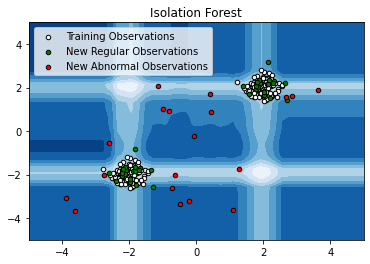

In [90]:
#Plot

xx, yy=np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
Z=clf.decision_function(clf,np.c_[xx.ravel(), yy.ravel()])
Z=Z.reshape(xx.shape)

plt.title("Isolation Forest")
plt.contourf(xx,yy,Z,cmap=plt.cm.Blues_r)

b1=plt.scatter(X_train[:,0],X_train[:,1], c='white',s=20,edgecolors='k')
b2=plt.scatter(X_test[:,0],X_test[:,1],c='green',s=20, edgecolors='k')
c=plt.scatter(X_outliers[:,0],X_outliers[:,1],c='red',s=20,edgecolors='k')

plt.axis('tight')
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.legend([b1,b2,c],["Training Observations",
                        "New Regular Observations", "New Abnormal Observations"],
                loc="upper left")
plt.show()